# Frank-Wolfe algorithm on constrained Lasso problem

Author: Alexandre Gramfort

Problem considered is:

$$
\min \|Ax-b\|^2  s.t. \|x\|_1 \leq r
$$


In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_samples = 150
n_features =20
nnz = n_features // 4  # number of non-zeros in the true solution

rng = np.random.RandomState(42)
A = rng.randn(n_samples, n_features)
xstar = np.concatenate((np.ones(nnz), -np.ones(nnz), -np.zeros(n_features - 2*nnz)))

noise = 0.1 * rng.randn(n_samples)
b = A.dot(xstar) + noise

def lasso_frank_wolfe(A, b, r, max_iter, use_linesearch, verbose=True):
    x = np.zeros(A.shape[1])
    Ax = np.dot(A, x)
    pobj = []
    for k in range(1, max_iter):
        # call the LMO
        i = np.argmax(np.abs(np.dot(A.T, Ax - b)))

        step_sign = np.sign(np.dot(A[:, i].T, b - Ax))  # sign of -gradF[i]
        s = np.zeros(n_features)
        s[i] = step_sign * r;
        As = step_sign * r * A[:, i]  # = the i-th column of the design matrix A

        if use_linesearch:  # line-search on the univariate quadratic problem in gamma
            As_minus_Ax = As - Ax;
            gamma = np.dot(As_minus_Ax.T, b - Ax) / np.dot(As_minus_Ax, As_minus_Ax)
            gamma = max(0, min(1, gamma))  # project in [0, 1]
        else:
            gamma = 2 / (k + 2)

        x = (1. - gamma) * x + gamma * s  # do the FW step
        Ax = (1 - gamma) * Ax + gamma * As;  # lazy update of Ax

        f_at_x = linalg.norm(Ax - b)**2 / 2.
        if verbose:
            print('k=%d - f=%f - i=%d - gamma=%d' % (k, f_at_x, i, gamma));

        pobj.append(f_at_x)

    return pobj, x

r = 1  # the regularization constraint imposed on the l_1-norm
pobj_ls, x = lasso_frank_wolfe(A, b, r, max_iter=10, use_linesearch=True)

k=1 - f=575.955445 - i=4 - gamma=1
k=2 - f=543.163934 - i=6 - gamma=0
k=3 - f=539.537744 - i=9 - gamma=0
k=4 - f=537.377649 - i=2 - gamma=0
k=5 - f=537.326648 - i=6 - gamma=0
k=6 - f=537.323735 - i=5 - gamma=0
k=7 - f=537.320850 - i=2 - gamma=0
k=8 - f=537.320196 - i=4 - gamma=0
k=9 - f=537.318746 - i=6 - gamma=0


### Plot result

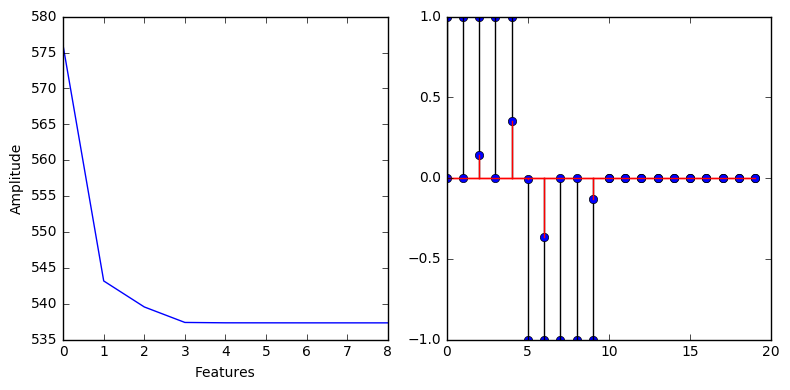

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(pobj_ls)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective')

ax2.stem(xstar, 'k')
ax2.stem(x, 'r')
ax1.set_xlabel('Features')
ax1.set_ylabel('Amplitude')
plt.tight_layout();

## Look at convergence rates

First compute $f^*$ by running solver many iterations

In [4]:
pobj, _ = lasso_frank_wolfe(A, b, r, max_iter=5000, use_linesearch=True, verbose=False)
f_star = np.min(pobj)

The plot objective:

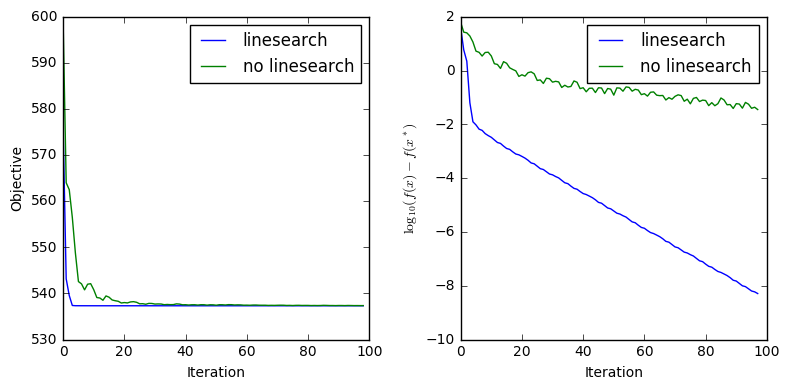

In [5]:
max_iter = 100
pobj_ls, _ = lasso_frank_wolfe(A, b, r, max_iter=max_iter, use_linesearch=True, verbose=False)
pobj_no_ls, _ = lasso_frank_wolfe(A, b, r, max_iter=max_iter, use_linesearch=False, verbose=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(pobj_ls, label='linesearch')
ax1.plot(pobj_no_ls, label='no linesearch')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective')
ax1.legend()

ax2.plot(np.log10(pobj_ls[:-1] - f_star), label='linesearch')
ax2.plot(np.log10(pobj_no_ls[:-1] - f_star), label='no linesearch')
ax2.set_xlabel('Iteration')
ax2.set_ylabel(r'$\log_{10}(f(x) - f(x^*)$')
ax2.legend()
plt.tight_layout();